<a href="https://colab.research.google.com/github/sirakik/japan_graph/blob/master/%E3%82%B3%E3%83%AD%E3%83%8A%E3%83%87%E3%83%BC%E3%82%BF%E8%A6%96%E5%AF%9F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#下ごしらえ

In [186]:
import csv
import datetime
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5.0, 5.0)

In [187]:
!wget -q https://raw.githubusercontent.com/kaz-ogiwara/covid19/master/data/prefectures.csv -O corona.csv

# データ読み込み

testedPositive: 検査陽性者数  
peopleTested: 検査実施人数  
hospitalized: 入院治療等を要する者  
serious: 重症者数  
discharged: 退院・療養解除  
deaths: 死亡者数  
effectiveReproductionNumber: 実効再生産数

In [188]:
dt1 = datetime.datetime(year=2020, month=2, day=8) #　2月8日からデータが始まっています
dt2 = datetime.datetime(year=2020, month=9, day=13) # ほぼ毎日更新っぽいので，今日の日付に合わせましょう．ただし何時更新かは知らないので，手作業で合わせてください
dif_days = (dt2 - dt1).days +1
print('#　日数: ', dif_days)

#　日数:  219


In [189]:
# 都道府県名 (データに合わせて, GummaをGunmaに変更)
todofuken = {0:'Hokkaido', 1:'Aomori', 2:'Iwate', 3:'Miyagi', 4:'Akita', 5:'Yamagata', 6:'Fukushima', 7:'Ibaraki', 8:'Tochigi', 9:'Gunma', 10:'Saitama', 11:'Chiba', 12:'Tokyo', 13:'Kanagawa', 14:'Niigata', 15:'Toyama', 16:'Ishikawa', 17:'Fukui', 18:'Yamanashi', 19:'Nagano', 20:'Gifu', 21:'Shizuoka', 22:'Aichi', 23:'Mie', 24:'Shiga', 25:'Kyoto', 26:'Osaka', 27:'Hyogo', 28:'Nara', 29:'Wakayama', 30:'Tottori', 31:'Shimane', 32:'Okayama', 33:'Hiroshima', 34:'Yamaguchi', 35:'Tokushima', 36:'Kagawa', 37:'Ehime', 38:'Kochi', 39:'Fukuoka', 40:'Saga', 41:'Nagasaki', 42:'Kumamoto', 43:'Oita', 44:'Miyazaki', 45:'Kagoshima', 46:'Okinawa'}

def find_key(value):
    for k, v in todofuken.items():
        if value == v:
          return k

###新規感染者数

In [194]:
daily_infected = np.zeros((47, dif_days))
last_discharged = np.zeros(47)
with open('corona.csv') as f:
    corona_data = csv.reader(f)
    # ヘッダー削除
    next(corona_data)
    for i, d in enumerate(corona_data):
        # 都道府県番号を取得
        key = find_key(d[4])
        # 日付を配列番号に変更
        dt = datetime.datetime(year=int(d[0]), month=int(d[1]), day=int(d[2]))
        index = (dt - dt1).days
        # 新規感染者数を格納
        daily_infected[key][index] = float(d[5])

# 累計感染者が減ることがある. 減った場合は新規感染者数を0とした.
last_infected = daily_infected[:, 0:1].flatten()
for key, todo in enumerate(daily_infected):
    for n, d in enumerate(todo):
        if n == 0:
            continue
        dis = d - last_infected[key]
        if dis < 0:
            dis = 0
        daily_infected[key][n] = dis
        last_infected[key] = d

###検査数

検査数が報告されてない場合もある．
その場合は前日と同様とする

In [195]:
daily_tested = np.zeros((47, dif_days))
with open('corona.csv') as f:
    corona_data = csv.reader(f)
    # ヘッダー削除
    next(corona_data)
    for i, d in enumerate(corona_data):
        # 都道府県番号を取得
        key = find_key(d[4])
        # 日付を配列番号に変更
        dt = datetime.datetime(year=int(d[0]), month=int(d[1]), day=int(d[2]))
        index = (dt - dt1).days
        # 新規感染者数を格納
        if d[6] == '':
            continue
        else:
            daily_tested[key][index] = float(d[6])

# その日のデータがない場合, 前日の検査数と同じにする（あんまりよくない?）
last_tested = daily_tested[:, 0:1].flatten()
for key, todo in enumerate(daily_tested):
    for n, d in enumerate(todo):
        if n == 0:
            continue
        if last_tested[key] == d:
            daily_tested[key][n] = daily_tested[key][n-1]
        else:
            daily_tested[key][n] = d - last_tested[key]
            last_tested[key] = d

###感染率 (感染者数 / 検査数)
何かがおかしい 70

In [196]:
daily_rate = (daily_infected / daily_tested)

# 感染者0でも検査数がN 0/N = nan :感染率を0とする
daily_rate = np.where(np.isnan(daily_rate), 0, daily_rate)

#　感染者数がいるのに，検査数が0のとき N/0 = inf
# 前日と同じとする. 前日がない2月8日は強制的に感染率を0とする.
for key, todo in enumerate(daily_rate):
    for i, d in enumerate(todo):
        if d == np.inf:
            if i != 0:
                daily_rate[key][i] = daily_rate[key][i-1]
            else:
                daily_rate[key][i] = 0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


# 新規感染者数


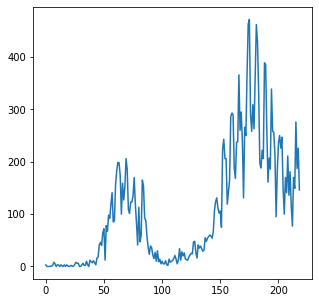

# 新規検査数
# 日曜日は検査数が減ります


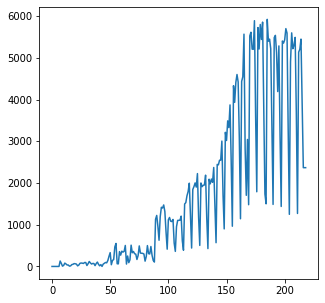

# 感染率 (感染者数 / 検査数)


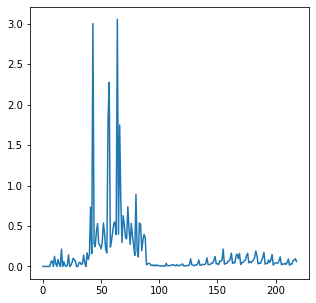

In [197]:
 # 可視化

sam = 'Tokyo'

key = find_key(sam)
if key is None:
  raise ValueError('# 都道府県名が正しくないね.')
x = list(range(dif_days))

print('# 新規感染者数')
y = daily_infected[key]
plt.plot(x, y)
plt.show()

print('# 新規検査数')
print('# 日曜日は検査数が減ります')
y = daily_tested[key]
plt.plot(x, y)
plt.show()

print('# 感染率 (感染者数 / 検査数)')
y = daily_rate[key]
plt.plot(x, y)
plt.show()